Estimate a DWI signal using the eddymotion Gaussian Process (GP) regressor estimator.

Download the "Sherbrooke 3-shell" dataset using DIPY and select the b=1000 s/mm^2 shell data.

In [1]:
import dipy.data as dpd
import nibabel as nib
import numpy as np
from dipy.core.gradients import get_bval_indices
from dipy.io import read_bvals_bvecs
from dipy.segment.mask import median_otsu

from scipy.ndimage import binary_dilation
from skimage.morphology import ball

seed = 1234
rng = np.random.default_rng(seed)

name = "sherbrooke_3shell"

dwi_fname, bval_fname, bvec_fname = dpd.get_fnames(name=name)
dwi_data = nib.load(dwi_fname).get_fdata()
bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)

_, brain_mask = median_otsu(dwi_data, vol_idx=[0])
brain_mask = binary_dilation(brain_mask, ball(8))

bval = 1000
indices = get_bval_indices(bvals, bval, tol=20)

bvecs_shell = bvecs[indices]
shell_data = dwi_data[..., indices]

Visualize a slice of the data for a given DWI volume.

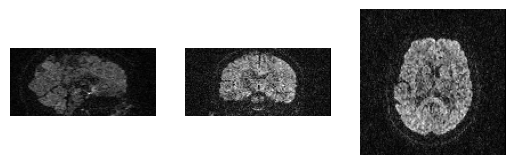

In [2]:
# Plot a slice
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

dwi_vol_idx = len(indices) // 2
slice_idx = list(map(int, np.divide(dwi_data.shape[:-1], 2)))

x_slice = dwi_data[slice_idx[0], :, :, dwi_vol_idx]
y_slice = dwi_data[:, slice_idx[1], :, dwi_vol_idx]
z_slice = dwi_data[:, :, slice_idx[2], dwi_vol_idx]
slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, _slice in enumerate(slices):
    axes[i].imshow(_slice.T, cmap="gray", origin="lower", aspect='equal')
    axes[i].set_axis_off()

plt.show()

Define the EddyMotionGPR instance.

In [3]:
from eddymotion.model.gpr import EddyMotionGPR, SphericalKriging

beta_a = 1.38
beta_l = 1 / 2.1
kernel = SphericalKriging(beta_a=beta_a, beta_l=beta_l)

alpha = 0.1
disp = True
optimizer = None
gpr = EddyMotionGPR(kernel=kernel, alpha=alpha, disp=disp, optimizer=optimizer)


Let's leave one direction out:

In [4]:
# Prepare a train/test mask (False for all directions except the left-out where it's true)
train_test_mask = np.zeros(bvecs_shell.shape[0], dtype=bool)
train_test_mask[dwi_vol_idx] = True

# Generate train/test bvecs
X_train = bvecs_shell[~train_test_mask, :]
X_test = bvecs_shell[train_test_mask, :]

# Select voxels within brain mask
y = shell_data[brain_mask]

# Generate train/test data
y_train = y[:, ~train_test_mask]
y_test = y[:, train_test_mask]

Do not optimize the parameters in the fitting. 

In [5]:
gpr = gpr.fit(X_train, y_train.T)

y_sim = np.squeeze(gpr.predict(X_test))

dwi_sim = np.zeros_like(shell_data[..., 0])
dwi_sim[brain_mask] = y_sim

And now, visualize:

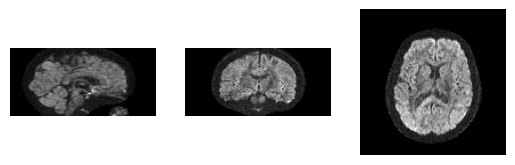

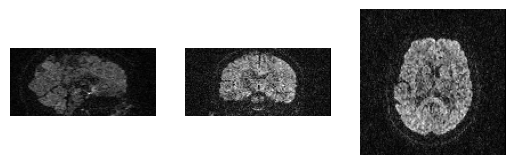

In [6]:

x_slice = dwi_sim[slice_idx[0], :, :]
y_slice = dwi_sim[:, slice_idx[1], :]
z_slice = dwi_sim[:, :, slice_idx[2]]
slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, _slice in enumerate(slices):
     axes[i].imshow(_slice.T, cmap="gray", origin="lower", aspect='equal')
     axes[i].set_axis_off()

plt.show()

x_slice = dwi_data[slice_idx[0], :, :, dwi_vol_idx]
y_slice = dwi_data[:, slice_idx[1], :, dwi_vol_idx]
z_slice = dwi_data[:, :, slice_idx[2], dwi_vol_idx]
slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, _slice in enumerate(slices):
    axes[i].imshow(_slice.T, cmap="gray", origin="lower", aspect='equal')
    axes[i].set_axis_off()

plt.show()

Predict on a randomly picked diffusion-encoding gradient direction.

In [7]:
rmse = np.sqrt((y_test.squeeze() - y_sim) ** 2)

print(f"RMSE: {rmse.mean()}")
threshold = 10
n_error_thr = len(rmse[rmse > threshold])
ratio = n_error_thr / len(rmse) * 100
print(f"Number of RMSE values above {threshold}: {n_error_thr} ({ratio:.2f}%)")

RMSE: 20.092110897117276
Number of RMSE values above 10: 199698 (67.21%)


Select a number of brain voxels at random to perform the GP parameter optimization. The same voxels will be selected across each DWI volume.

In [8]:
n_voxels = 10000
true_indices = np.argwhere(brain_mask)

# Sample indices randomly
num_samples = min(n_voxels, len(true_indices))
sampled_indices = true_indices[np.random.choice(len(true_indices), num_samples, replace=False)]

sampled_dwi = shell_data[sampled_indices[:, 0], sampled_indices[:, 1], sampled_indices[:, 2], :].T

Let's now allow our GP to fit a and λ on the full dataset

In [14]:
gpr = EddyMotionGPR(kernel=kernel, alpha=alpha, disp=disp, optimizer="fmin_l_bfgs_b", ftol=0.1)
gpr = gpr.fit(bvecs_shell, y.T)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.16597D+07    |proj g|=  7.64969D+00

At iterate    1    f=  3.02802D+07    |proj g|=  8.01781D+00

At iterate    2    f=  2.96130D+07    |proj g|=  7.92633D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      3     0     0   7.926D+00   2.961D+07
  F =   29612979.200755097     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


Now we check the fitted parameters:

In [15]:
gpr.kernel_, gpr.kernel

(SphericalKriging (a=0.8841585520664049, λ=2.769244783648302),
 SphericalKriging (a=1.38, λ=0.47619047619047616))

Let's create a new GPR with the new parameters (we should check this, I don't understand why the fitted parameters are not set back)

In [16]:
gpr = EddyMotionGPR(kernel=gpr.kernel_, alpha=alpha, disp=disp, optimizer=None)
gpr = gpr.fit(X_train, y_train.T)
y_sim2 = np.squeeze(gpr.predict(X_test))

dwi_sim2 = np.zeros_like(shell_data[..., 0])
dwi_sim2[brain_mask] = y_sim2

Let's check RMSE

In [17]:
rmse = np.sqrt((y_test.squeeze() - y_sim2) ** 2)

print(f"RMSE: {rmse.mean()}")
threshold = 10
n_error_thr = len(rmse[rmse > threshold])
ratio = n_error_thr / len(rmse) * 100
print(f"Number of RMSE values above {threshold}: {n_error_thr} ({ratio:.2f}%)")

RMSE: 21.310449692859184
Number of RMSE values above 10: 204399 (68.79%)


And now we visualize the new simulated orientation

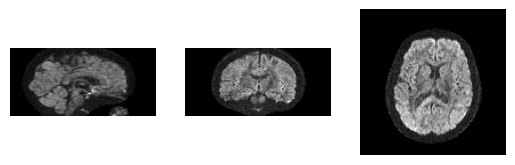

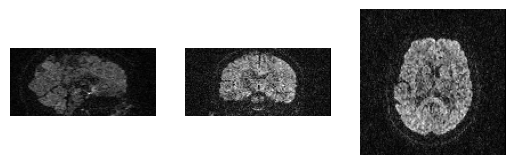

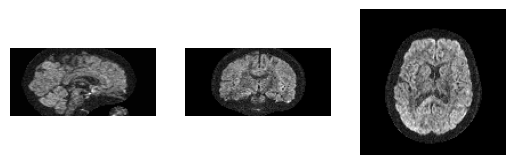

In [18]:
x_slice = dwi_sim[slice_idx[0], :, :]
y_slice = dwi_sim[:, slice_idx[1], :]
z_slice = dwi_sim[:, :, slice_idx[2]]
slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, _slice in enumerate(slices):
     axes[i].imshow(_slice.T, cmap="gray", origin="lower", aspect='equal')
     axes[i].set_axis_off()

plt.show()


x_slice = dwi_data[slice_idx[0], :, :, dwi_vol_idx]
y_slice = dwi_data[:, slice_idx[1], :, dwi_vol_idx]
z_slice = dwi_data[:, :, slice_idx[2], dwi_vol_idx]
slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, _slice in enumerate(slices):
    axes[i].imshow(_slice.T, cmap="gray", origin="lower", aspect='equal')
    axes[i].set_axis_off()

plt.show()

x_slice = dwi_sim2[slice_idx[0], :, :]
y_slice = dwi_sim2[:, slice_idx[1], :]
z_slice = dwi_sim2[:, :, slice_idx[2]]
slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, _slice in enumerate(slices):
     axes[i].imshow(_slice.T, cmap="gray", origin="lower", aspect='equal')
     axes[i].set_axis_off()

plt.show()

I'm not sure the cross-validation effort and the rest is worth trying right now.

## Cross-validation

Use a k-fold cross-validation and a grid search to find the best parameters.

In [ ]:
# This is doubling-down the parameter optimization
# from sklearn.model_selection import GridSearchCV, KFold

# Define the hyperparameter grid
# param_grid = {
#     "kernel__beta_a": np.linspace(np.pi/4, np.pi/2, 2),
#     "kernel__beta_l": np.linspace(0.1, 1 / 2.1, 2),
#     "alpha": np.linspace(1e-3, 1e-2, 2)
# }

# Define k-fold cross-validation
# cv = KFold(n_splits=5, shuffle=True, random_state=seed)

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(estimator=gpr, param_grid=param_grid, cv=cv, scoring="neg_mean_squared_error")
# grid_search.fit(X_train, sampled_dwi)

# print(f"Best parameters found: {grid_search.best_params_}")
# print(f"Best cross-validation score: {-grid_search.best_score_}")

Train the GP leaving out a randomly picked diffusion-encoding gradient direction and predict on it using the optimized parameters

Define the GP instances with the optimized hiperparameters

In [ ]:
kernel = SphericalKriging(beta_a=grid_search.best_params_["kernel__beta_a"], beta_l=grid_search.best_params_["kernel__beta_l"])
gpr = EddyMotionGPR(kernel=kernel, alpha=grid_search.best_params_["alpha"], disp=disp, optimizer=optimizer)

Pick a random diffusion-encoding gradient direction and call fit/predict

In [ ]:
idx = rng.integers(0, len(indices))
idx_mask = np.zeros(len(indices), dtype=bool)
idx_mask[idx] = True

X_train = bvecs_shell[~idx_mask]
_dwi_mask = np.repeat(brain_mask[..., np.newaxis], X_train.shape[0], axis=-1)
y_train = shell_data[..., ~idx_mask][_dwi_mask].reshape((X_train.shape[0], -1))

gpr_fit = gpr.fit(X_train, y_train)

X_test = bvecs_shell[idx_mask]
y_pred = gpr_fit.predict(X_test)

Plot the data.

In [ ]:
x_slice = shell_data[..., idx][slice_idx[0], :, :]
y_slice = shell_data[..., idx][:, slice_idx[1], :]
z_slice = shell_data[..., idx][:, :, slice_idx[2]]
slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, _slice in enumerate(slices):
     axes[i].imshow(_slice.T, cmap="gray", origin="lower", aspect="equal")
     axes[i].set_axis_off()

plt.suptitle("Data")
plt.show()

# Reshape the predicted data array to the image shape
brain_mask_idx = np.where(brain_mask)
_y_pred = np.zeros((shell_data.shape[:-1]), dtype=y_train.dtype)
_y_pred[brain_mask_idx] = y_pred.squeeze()

x_slice = _y_pred[slice_idx[0], :, :]
y_slice = _y_pred[:, slice_idx[1], :]
z_slice = _y_pred[:, :, slice_idx[2]]
slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
for i, _slice in enumerate(slices):
     axes[i].imshow(_slice.T, cmap="gray", origin="lower", aspect="equal")
     axes[i].set_axis_off()

plt.suptitle("GP prediction")
plt.show()

Compute the RMSE and plot it

In [ ]:
# Multiply the data by the brain mask to remove spurious values that were not predicted
rmse = np.sqrt(np.mean(np.square(shell_data[..., idx]*brain_mask - _y_pred)))
_rmse_element = np.sqrt(np.square(shell_data[..., idx]*brain_mask - _y_pred))

print(f"RMSE: {rmse}")
threshold = 10
n_error_thr = len(_rmse_element[_rmse_element > threshold])
ratio = n_error_thr / np.prod(_rmse_element.shape) * 100
print(f"Number of RMSE values above {threshold}: {n_error_thr} ({ratio}%)")

# Plot the RSME
x_slice = _rmse_element[slice_idx[0], :, :]
y_slice = _rmse_element[:, slice_idx[1], :]
z_slice = _rmse_element[:, :, slice_idx[2]]
slices = [x_slice, y_slice, z_slice]

fig, axes = plt.subplots(1, len(slices))
images = []
for i, _slice in enumerate(slices):
     images.append(axes[i].imshow(_slice.T, cmap="viridis", origin="lower", aspect="equal"))
     axes[i].set_axis_off()

plt.colorbar(images[-1])
plt.suptitle("RMSE")
plt.show()